<a href="https://colab.research.google.com/github/rgprado/SeriesTemporais/blob/main/Series_Temporais_aula1_202201_Rodrigo_Prado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Análise de Séries Temporais
 
 **Professor**: Domingos Santos

 **Aluno**: Rodrigo Prado

**Atividade 1**:

 - selecionar 2 séries: uma financeira e uma adicional (sugestão, uma disponível no pydataset)
 - plot da média movél 
 - análise de quais componentes foram observados nas séries (Tendência, Sazonalidade e ciclos)
 - Calcularem o ACF e PACF das séries
 - analisar a série "sem_nome", identificar os componentes e defina essa série 

**Atividade 2**: para cada uma das séries:

- aplicar o KPSSTest;
- caso necessite aplique a diferenciação;
- avaliação se precisa aplicar mais diferenciações;



In [ ]:
!pip install yfinance pydataset pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 98.2 MB/s eta 0:00:00
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939432 sha256=b631eda062f06c7010f4ea4313ed30056a99bf4ff5e5d

In [ ]:
import yfinance as yf
from pydataset import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pmdarima.arima import KPSSTest, auto_arima

plt.rcParams["figure.figsize"] = (20,10)

initiated datasets repo at: /root/.pydataset/


In [ ]:
example_ma = [1,2,3,4,5,6,7,8,9,10]
ma_size=2

for i in range(ma_size, len(example_ma)):
  consider_val = example_ma[i-ma_size:i]
  print(f'valores considerados: {consider_val}, MA {np.mean(consider_val)}, valor atual {i}')

valores considerados: [1, 2], MA 1.5, valor atual 2
valores considerados: [2, 3], MA 2.5, valor atual 3
valores considerados: [3, 4], MA 3.5, valor atual 4
valores considerados: [4, 5], MA 4.5, valor atual 5
valores considerados: [5, 6], MA 5.5, valor atual 6
valores considerados: [6, 7], MA 6.5, valor atual 7
valores considerados: [7, 8], MA 7.5, valor atual 8
valores considerados: [8, 9], MA 8.5, valor atual 9


**Definição da função para cálculo da média movel**

In [ ]:
def show_trend(ts, ma_size):
  to_show = pd.DataFrame()

  to_show['serie'] = ts.values[ma_size:]
  to_show['MA']  = ts.rolling(ma_size).mean().values[ma_size:]
  to_show.plot()
  plt.show()

**Definição da Funçao DIFF**


In [ ]:
def difference(ts, interval=1):
  diff = list()

  for t in range(interval, ts.shape[0]):
    value = ts[t] - ts[t - interval]
    diff.append(value)


  return pd.Series(diff)

## Análise Financeira

In [ ]:
def get_yfinance(id_name):
  df = yf.Ticker(id_name)
  return  df.history(period="max")

In [ ]:
df_berkshire = get_yfinance('BRK-A')

In [ ]:
df_berkshire

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17 00:00:00-05:00,290.0,310.0,290.0,290.0,10000,0.0,0.0
1980-03-18 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
1980-03-19 00:00:00-05:00,290.0,310.0,290.0,290.0,20000,0.0,0.0
1980-03-20 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
1980-03-21 00:00:00-05:00,290.0,290.0,290.0,290.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-13 00:00:00-05:00,482430.0,482430.0,478000.0,481021.0,3900,0.0,0.0
2023-01-17 00:00:00-05:00,481590.0,483993.0,475695.0,476000.0,5700,0.0,0.0
2023-01-18 00:00:00-05:00,477497.0,479229.0,465831.0,466260.0,4100,0.0,0.0


**Análise:**

No gráfico de fechamento das ações da Berkshire Hathaway podemos observar uma tendência positiva na valorização das ações.

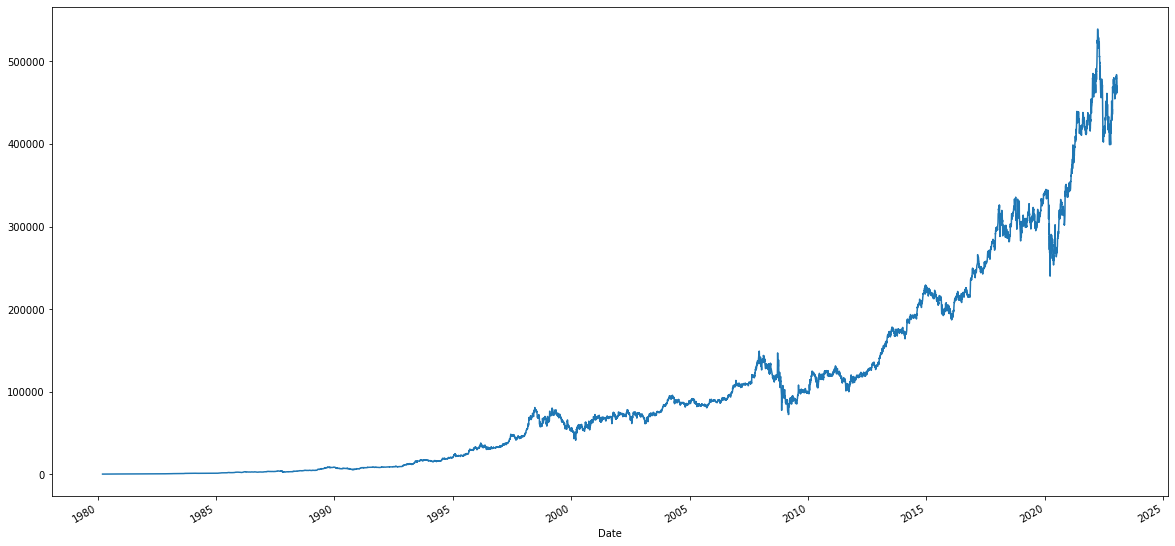

In [ ]:
df_berkshire['Close'].plot()

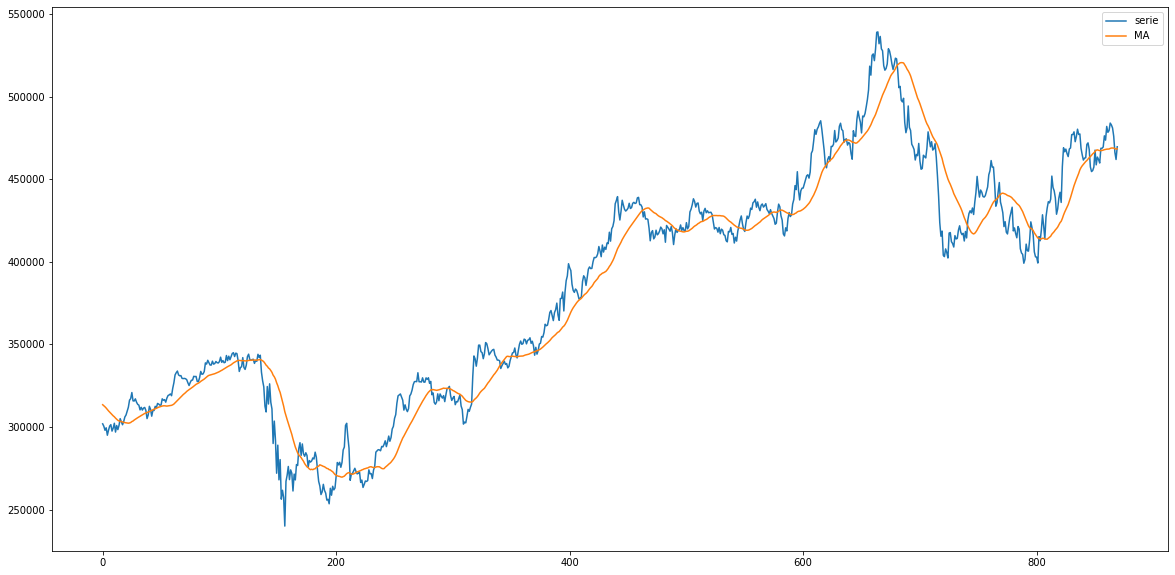

In [ ]:
ts = df_berkshire['Close'].iloc[-900:]
ma_size=30
show_trend(ts, ma_size)

**Análise**:

No gráfico de correlação acumulada, aparentemente existe uma correlação muit forte entre os dias, analisado com um lag de 20.

Mas fazendo a análise parcial da correlação, podemos ver que o gráfico apresenta uma característica "Random Walk", correlação forte com t-1, porém o restante bastante variado e com média próxima de zero.

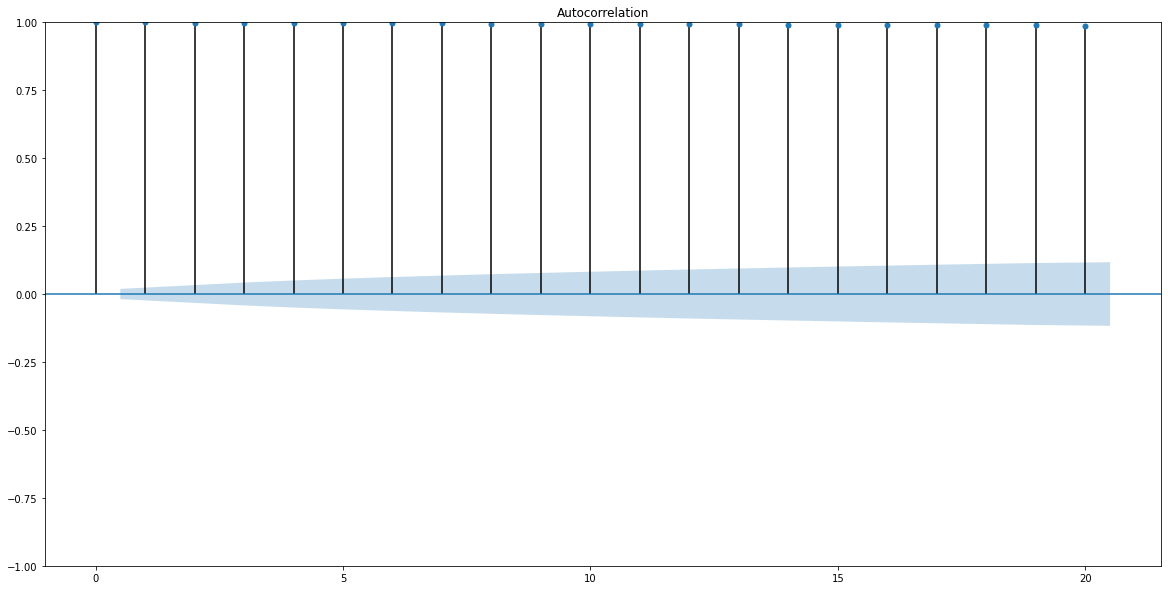

In [ ]:
sm.graphics.tsa.plot_acf(df_berkshire['Close'].values.squeeze(), lags=20)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


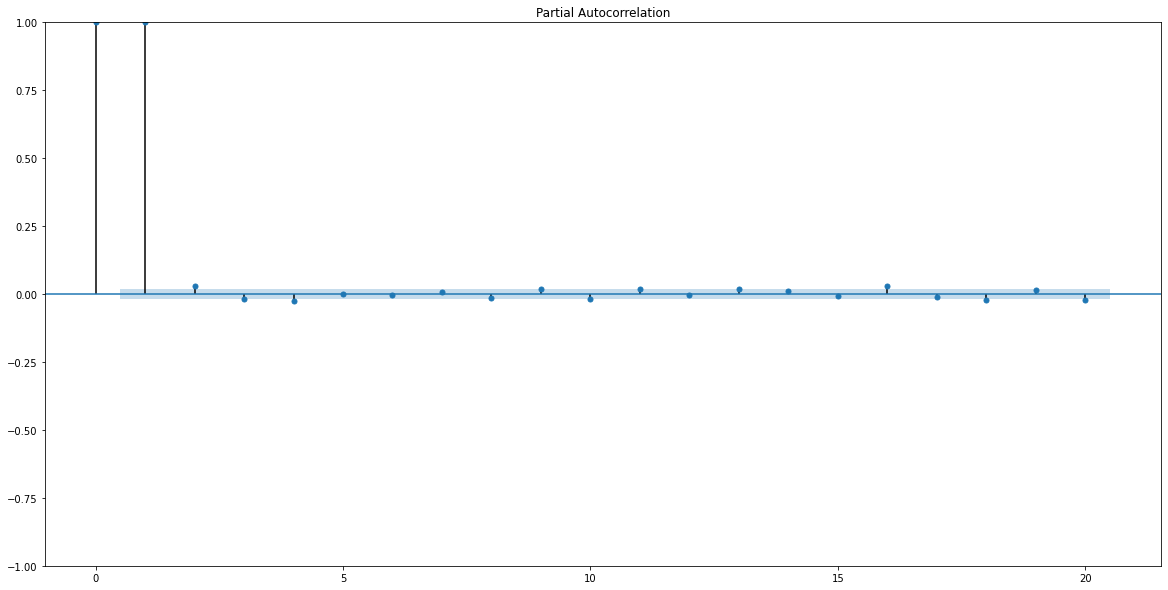

In [ ]:
sm.graphics.tsa.plot_pacf(df_berkshire['Close'].values.squeeze(), lags=20)

plt.show()

**Análise com função KPSSTest - Berkshire Hathaway**

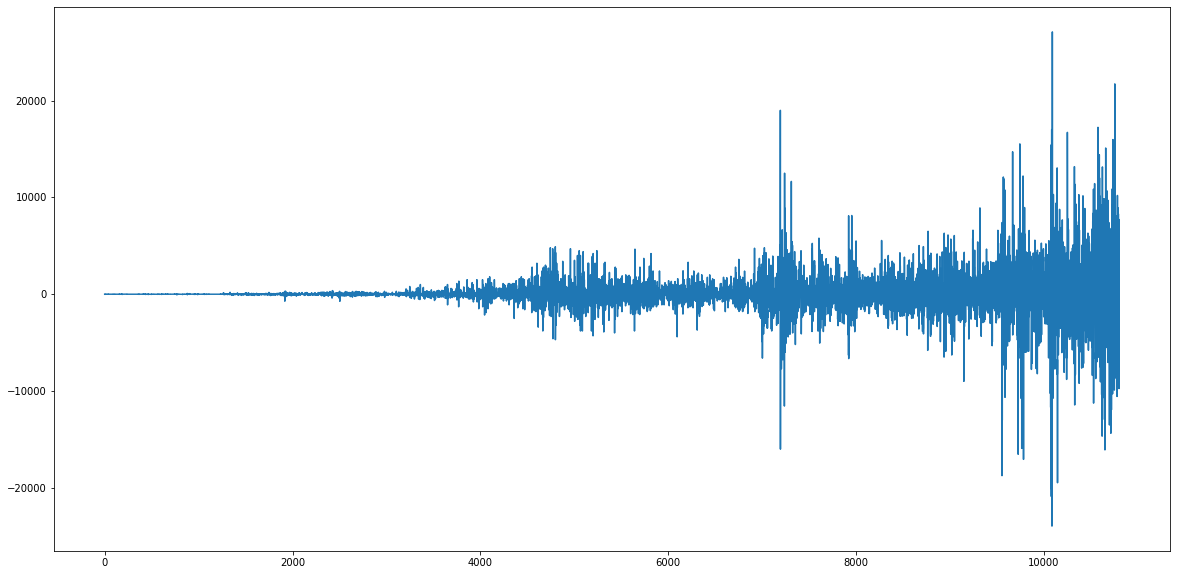

In [ ]:
diff_finance = difference(df_berkshire['Close']) # ou ts.diff()
diff_finance.plot()
plt.show()

In [ ]:
kps = KPSSTest()
kps.should_diff(df_berkshire['Close'])

(0.01, True)

**Análise**

Plot do ACF para o primeiro diff da série. 

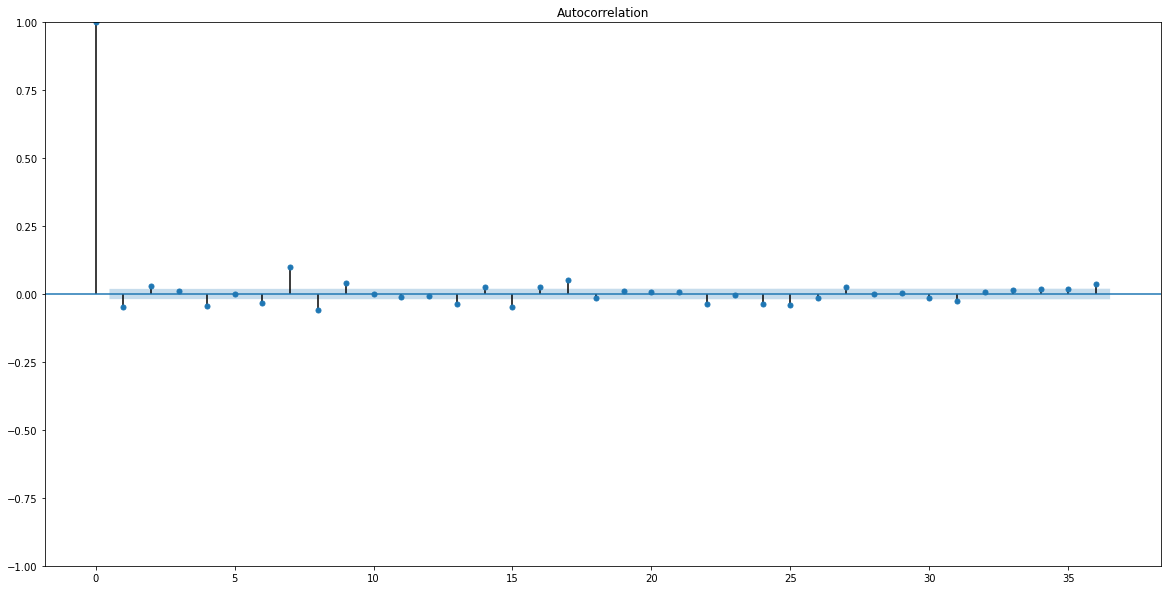

In [ ]:
sm.graphics.tsa.plot_acf(diff_finance, lags=36)
plt.show()

**Análise**

Plot do PACF para o primeiro diff da série. 

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


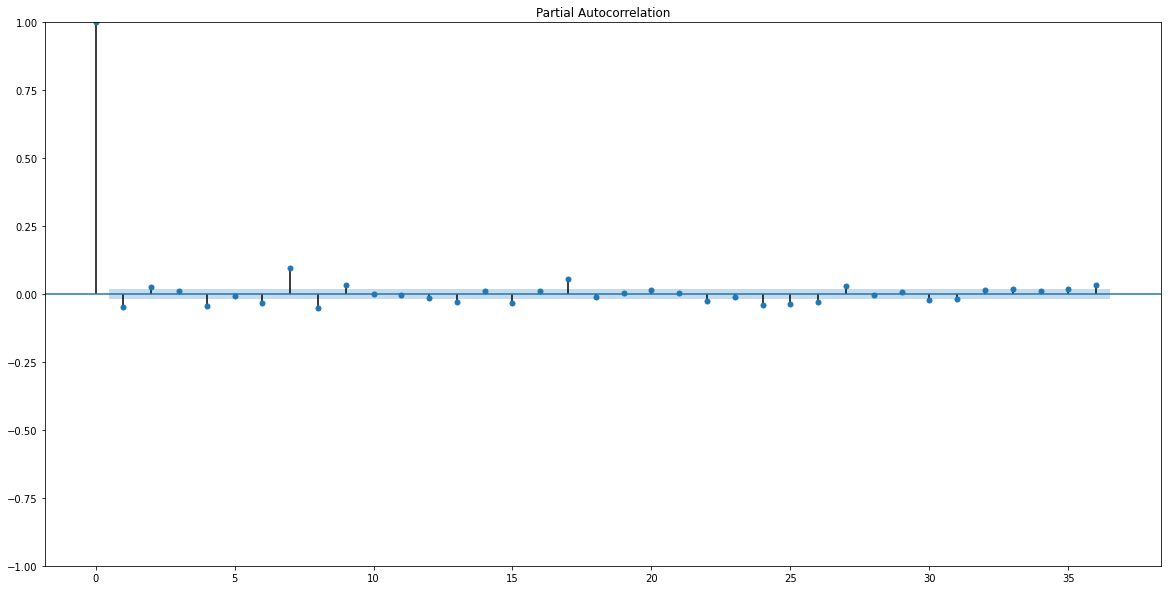

In [ ]:
sm.graphics.tsa.plot_pacf(diff_finance, lags=36)
plt.show()

**Análise**

Verificando se é necessário fazer mais um diff na série. O resposta indica que sim.

In [ ]:
kps.should_diff(diff_finance)

(0.030360902983885368, True)

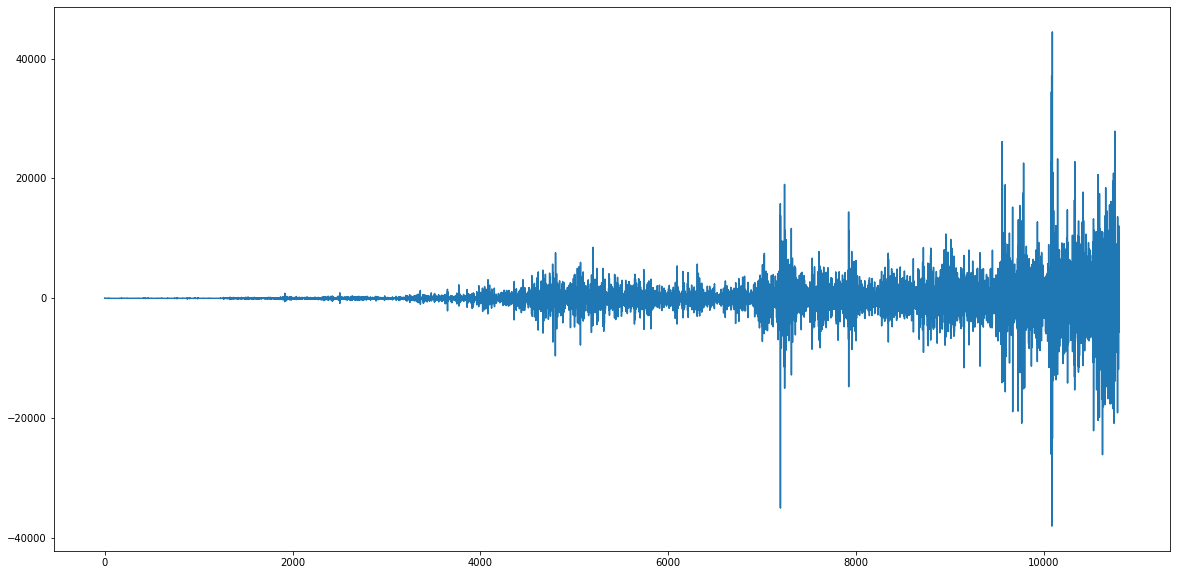

In [ ]:
diff_finance2 = difference(diff_finance) # ou ts.diff()
diff_finance2.plot()
plt.show()

**Análise gráfica**

Plot do ACF e PACF da segunda diferença

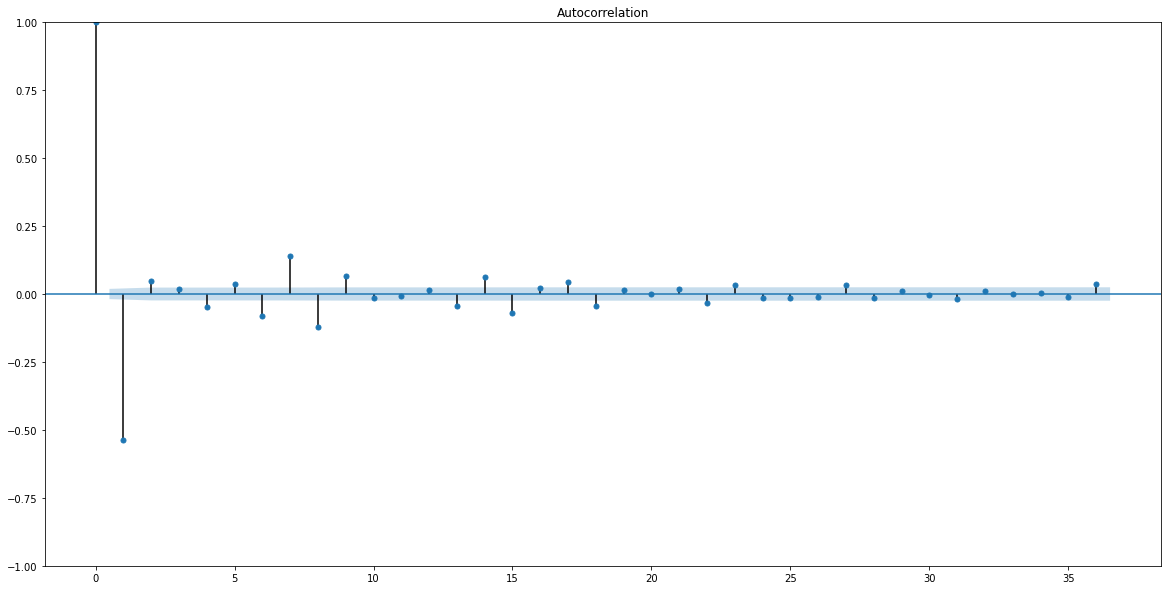

In [ ]:
sm.graphics.tsa.plot_acf(diff_finance2, lags=36)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


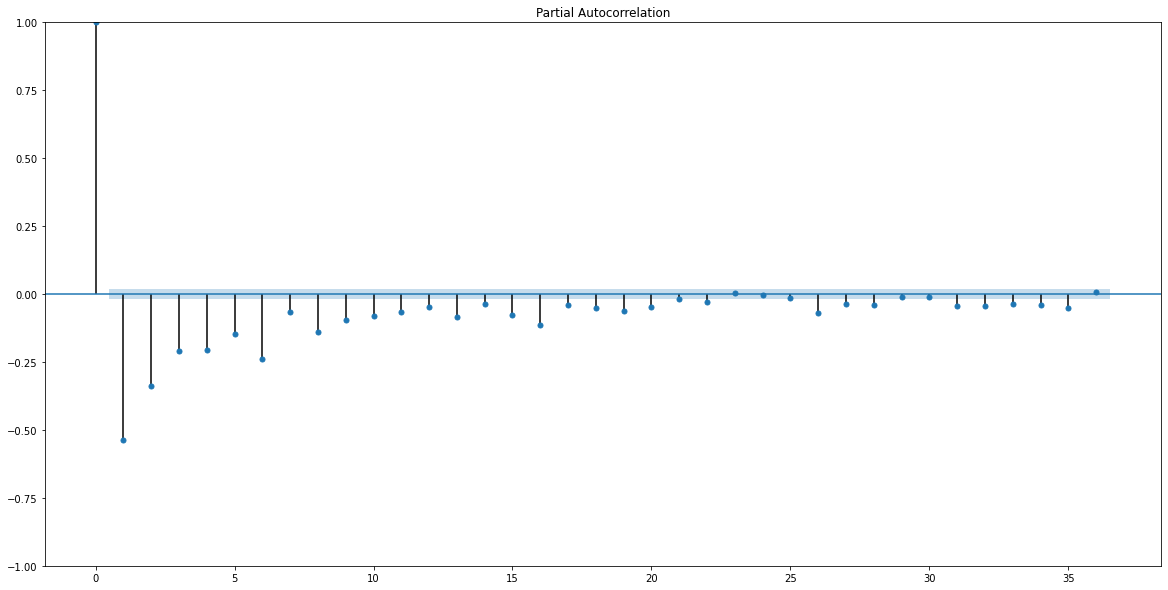

In [ ]:
sm.graphics.tsa.plot_pacf(diff_finance2, lags=36)
plt.show()

**Análise**

Novo KPSSTest, agora retorno falso.

In [ ]:
kps.should_diff(diff_finance2)

(0.1, False)

**Anáise**

De acordo com a função de KPSSTest, o dados de fechamento da Berkshire precisariam da função diff e mesmo depois da primeira passagem, ainda seria necessário fazer mais uma differença.

## Análise uma série temporal do pydataset

In [ ]:
timeseries_titles = ['AirPassengers', 'nottem', 'ambientNOxCH', 'acme', 'sunspot.year', 'UKDriverDeaths', 
                    'USAccDeaths', 'UKgas', 'JohnsonJohnson', 'Nile', 'LakeHuron', 'austres', 
                    'lynx', 'deaths', 'drivers']
                    
df_ukdrivers = data('UKDriverDeaths')

print(len(timeseries_titles))

15


In [ ]:
data('UKDriverDeaths', show_doc=True )

In [ ]:
df_ukdrivers['date'] = pd.date_range(start ='1969-01-01', end='1985-01-01', freq='M')

In [ ]:
df_ukdrivers.set_index('date', inplace=True)

**Análise**:

No gráfico de mortes mensais no Reino Unido não há tendência, mas aparentemente existe uma sazonalidade e ciclo. Confirmado nos gráficos de média mensal.

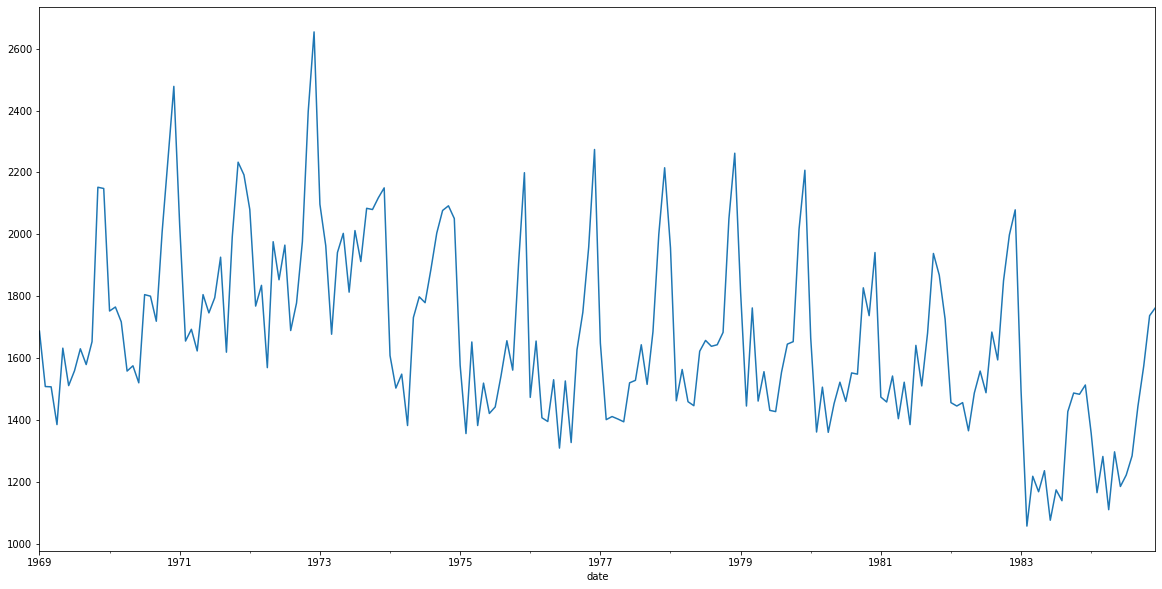

In [ ]:
df_ukdrivers['UKDriverDeaths'].plot()

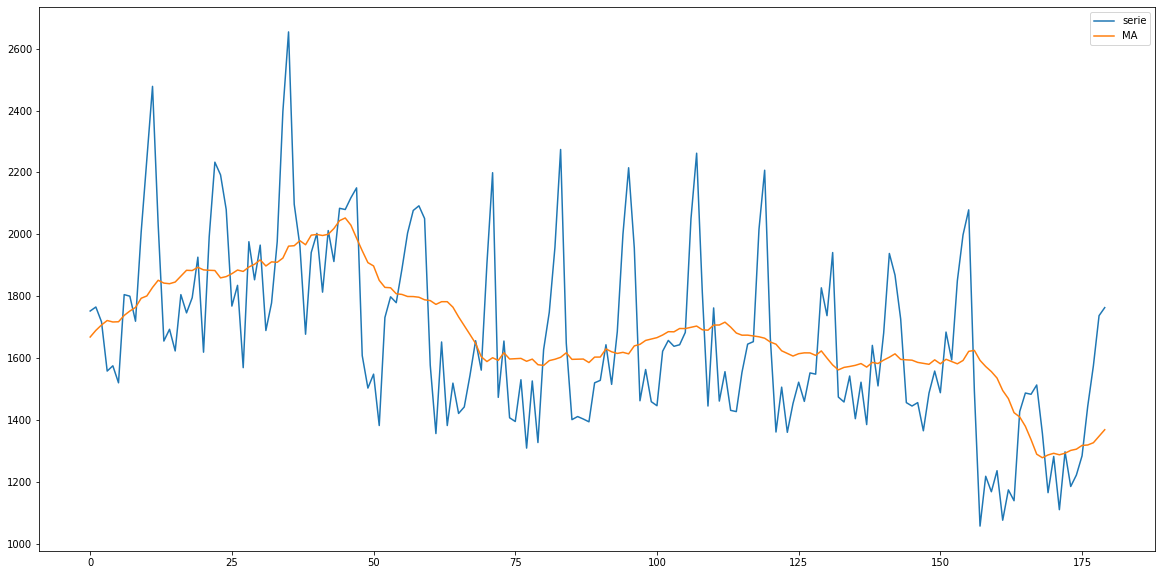

In [ ]:
ts = df_ukdrivers['UKDriverDeaths']
ma_size=12
show_trend(ts, ma_size)

**Análise**:

No gráfico de correlação acumulada, aparentemente existe uma correlação muito forte a cada 12 meses, indicando uma sazonalidade.

Na análise parcial da correlação, podemos ver que o gráfico apresenta uma característica de sazonalidade também, mas com correlação mais fraca nos depois de 12 e 24 meses.

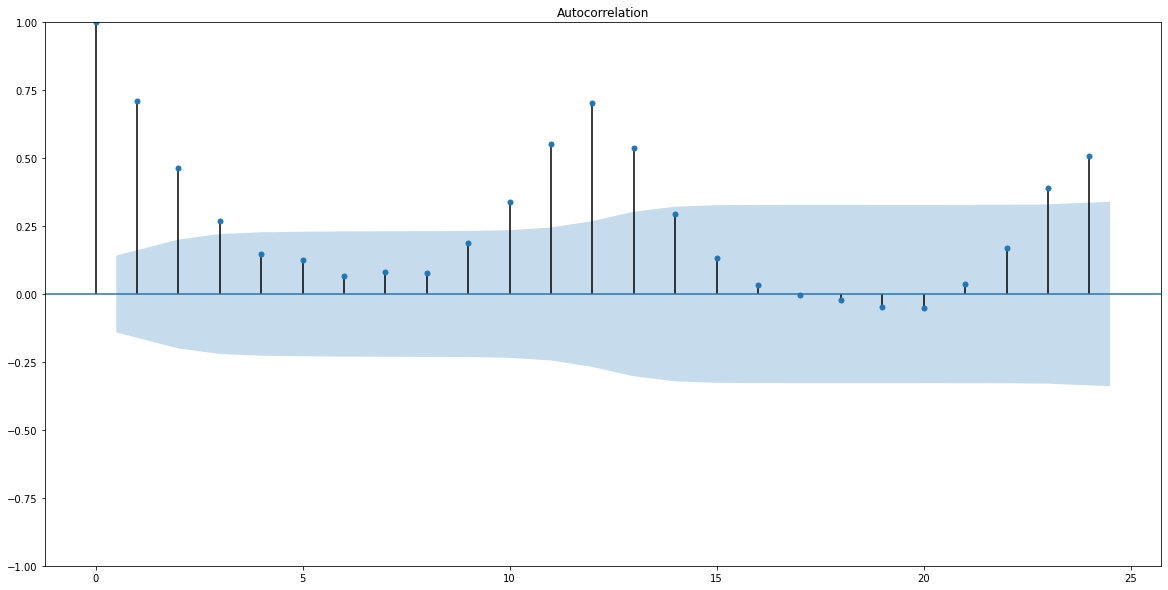

In [ ]:
sm.graphics.tsa.plot_acf(df_ukdrivers['UKDriverDeaths'].values.squeeze(), lags=24)

plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


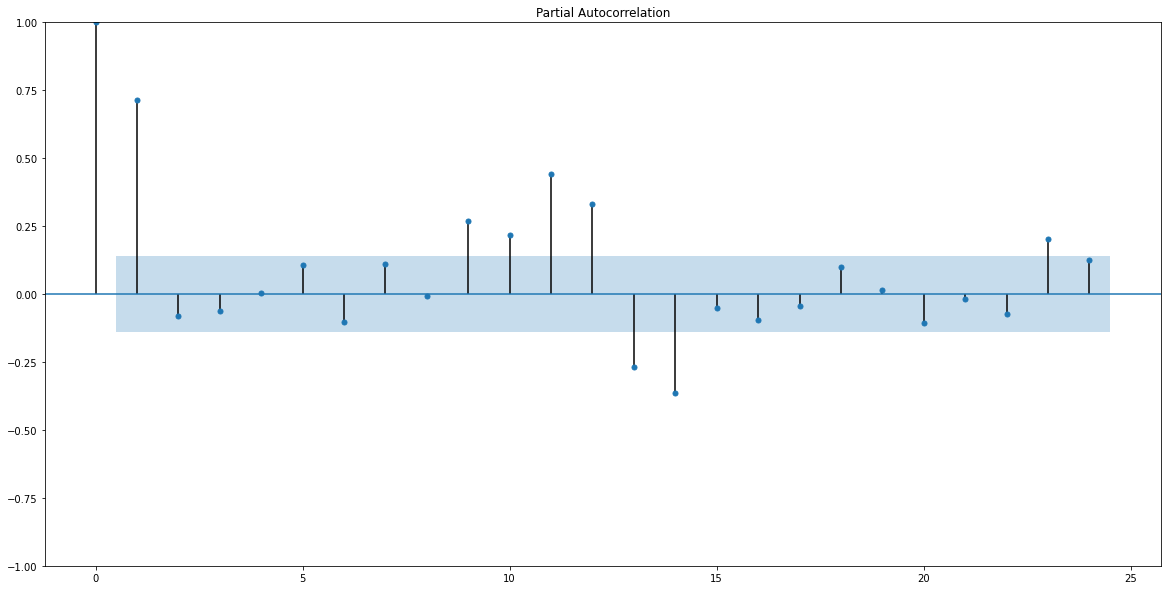

In [ ]:
sm.graphics.tsa.plot_pacf(df_ukdrivers['UKDriverDeaths'].values.squeeze(), lags=24)

plt.show()

**Análise com função KPSSTest - UKDriverDeaths**

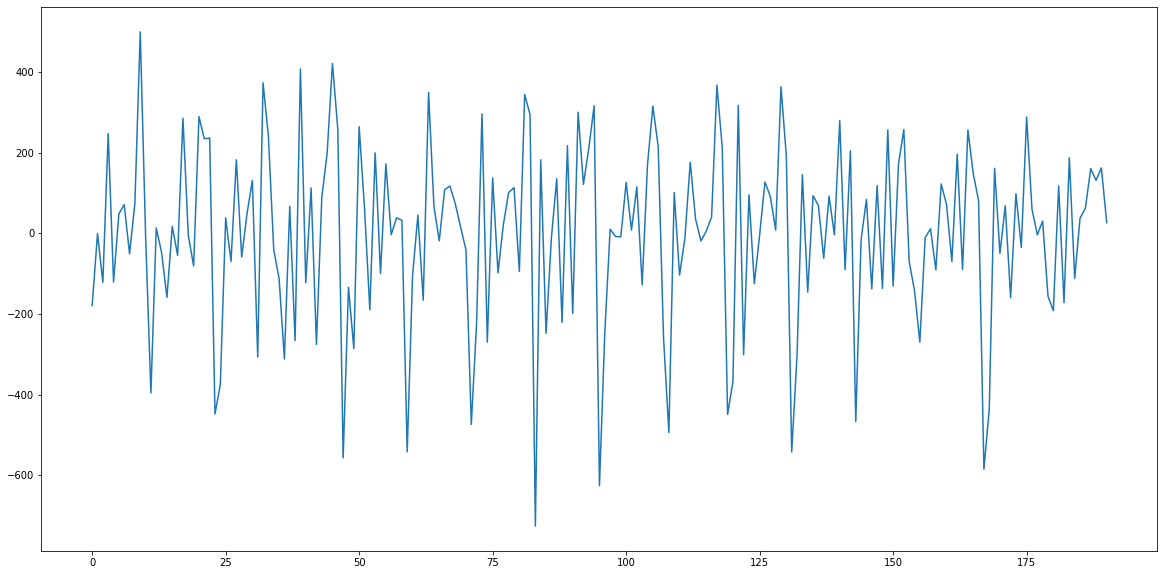

In [ ]:
diff_ukdrivers = difference(df_ukdrivers['UKDriverDeaths']) # ou ts.diff()
diff_ukdrivers.plot()
plt.show()

In [ ]:
kps.should_diff(df_ukdrivers['UKDriverDeaths'])

(0.01, True)

**Análise**

Plot do ACF para o primeiro diff da série UKDriverDeaths. 

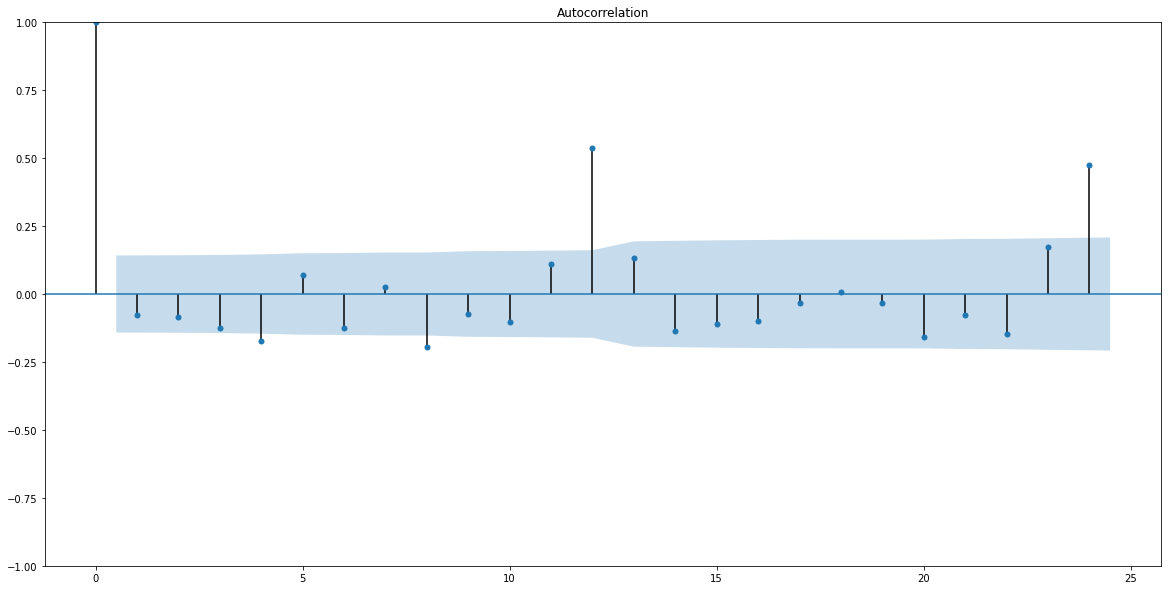

In [ ]:
sm.graphics.tsa.plot_acf(diff_ukdrivers, lags=24)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


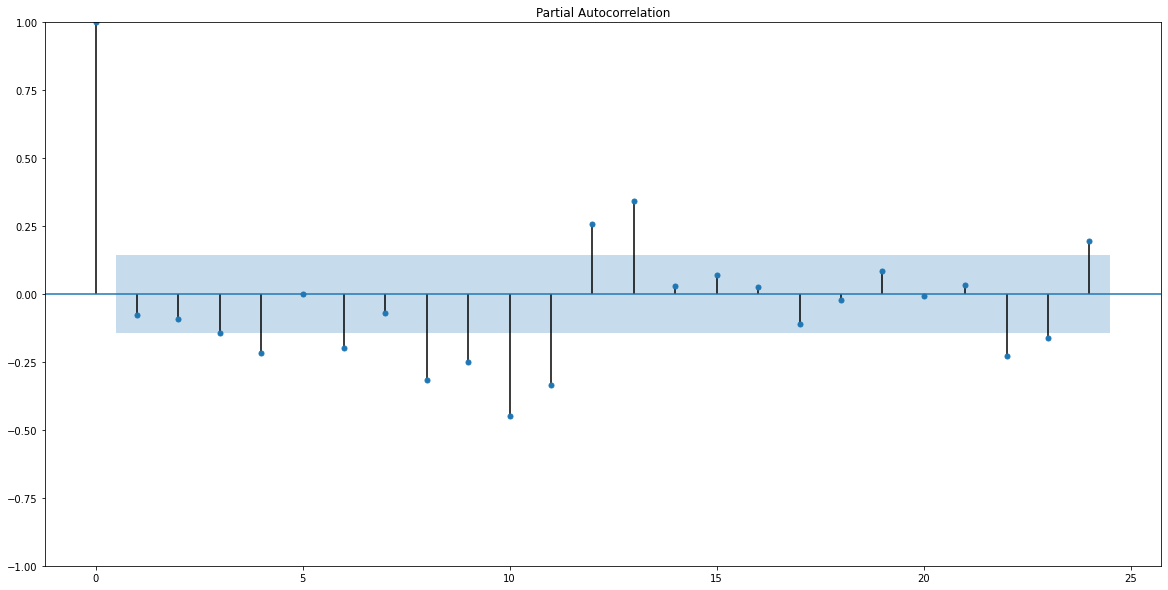

In [ ]:
sm.graphics.tsa.plot_pacf(diff_ukdrivers, lags=24)
plt.show()

In [ ]:
kps.should_diff(diff_ukdrivers)

(0.1, False)

**Anáise**

De acordo com a função de KPSSTest, o dados de acidentes do dataset UKDriverDeaths precisaria da função diff, mas depois do primeiro diff, o KPSSTest já indicou False no teste.

## Análise da série temporal "sem_nome"

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')
df_sem_nome = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dados/sem_nome.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
#df_sem_nome = pd.read_csv('sem_nome.csv')
#df_sem_nome

**Análise**:

Na plotagem de todos os dados temporais, aparentemente não há uma tendência, mesmo fazendo um corte dos últimos 200 dados, difícil analisar se existe uma sazonalidade e ciclos.

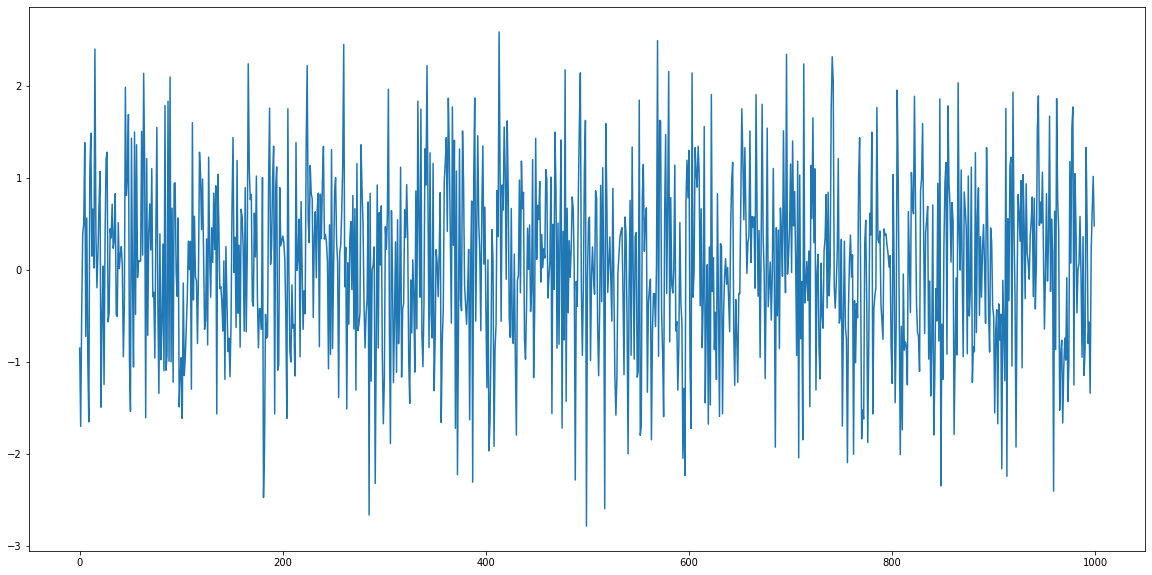

In [53]:
df_sem_nome['actual'].plot()

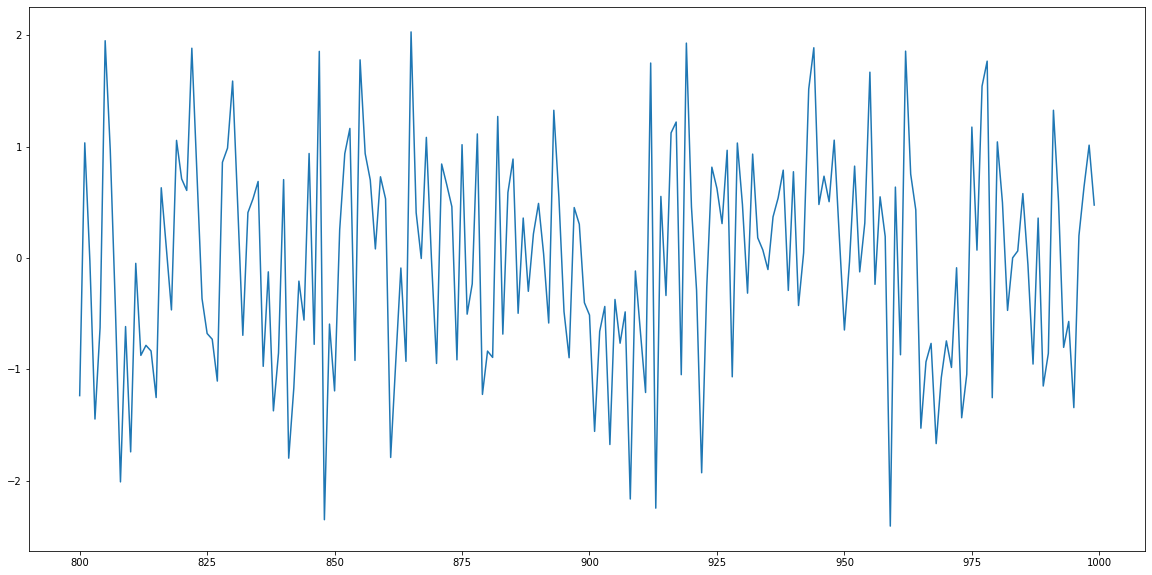

In [54]:
df_sem_nome['actual'].iloc[-200:].plot()

**Análise**:


Tanto no gráfico de correlação acumulada quanto na correlação parcial, não existe correlação entre os dados, nem mesmo no t-1. Média móvel bem próxima de zero indicando um caraterística de "Ruído Branco".

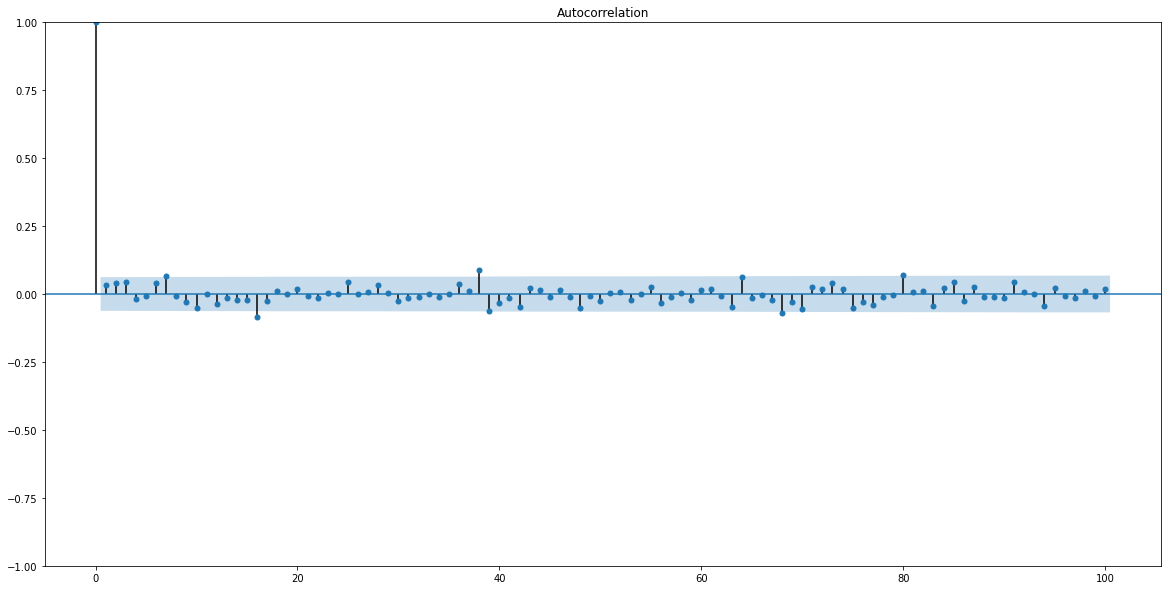

In [55]:
sm.graphics.tsa.plot_acf(df_sem_nome['actual'].values.squeeze(), lags=100)

plt.show()

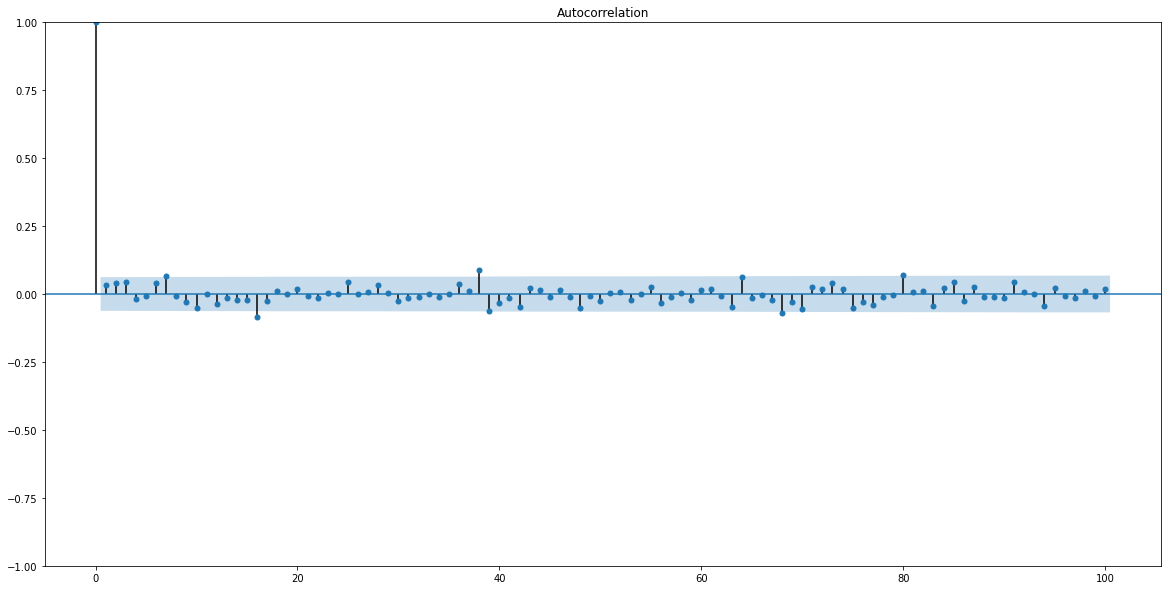

In [56]:
sm.graphics.tsa.plot_acf(df_sem_nome['actual'].values.squeeze(), lags=100)

plt.show()

**Análise com função KPSSTest - sem_nome dataset**

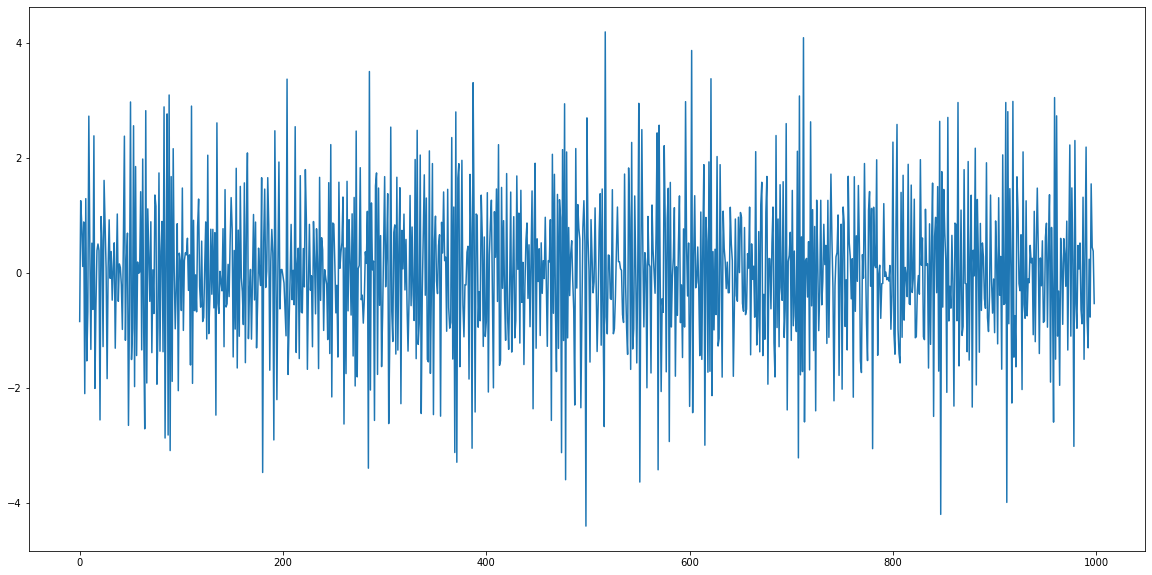

In [57]:
diff_semnome = difference(df_sem_nome['actual']) # ou ts.diff()
diff_semnome.plot()
plt.show()

In [58]:
kps.should_diff(df_sem_nome['actual'])

(0.1, False)

**Análise**

Verificando o KPSSTest para o dataset sem_nome, podemos ver que não seria necessário fazer o diff no dataset original.

Plotando os gráficos de ACF e PACF para o diff do dataset.

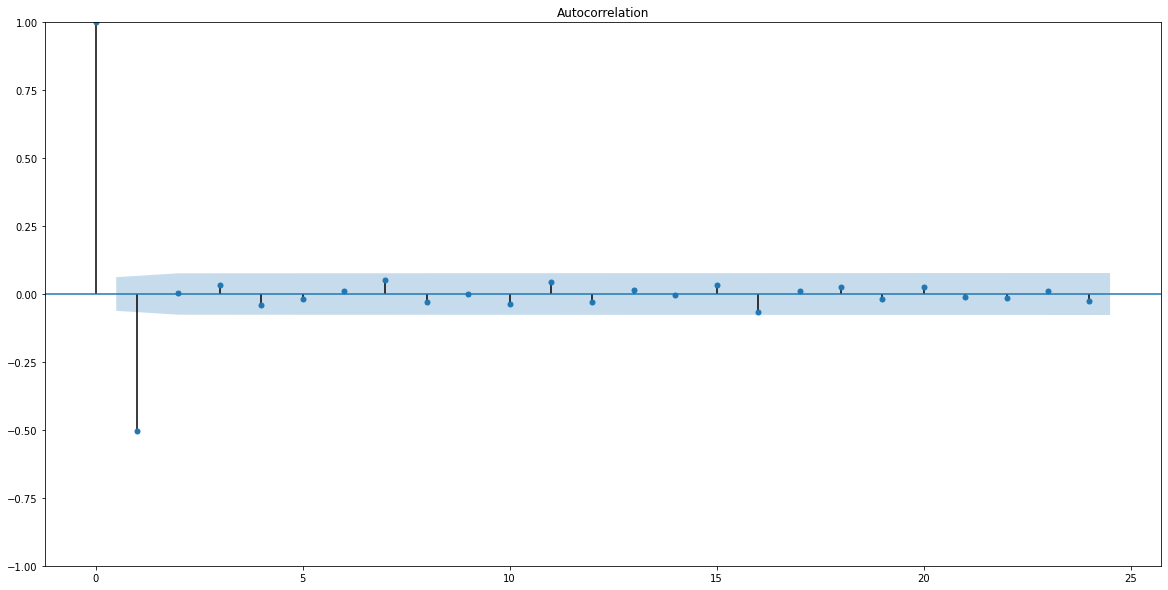

In [59]:
sm.graphics.tsa.plot_acf(diff_semnome, lags=24)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


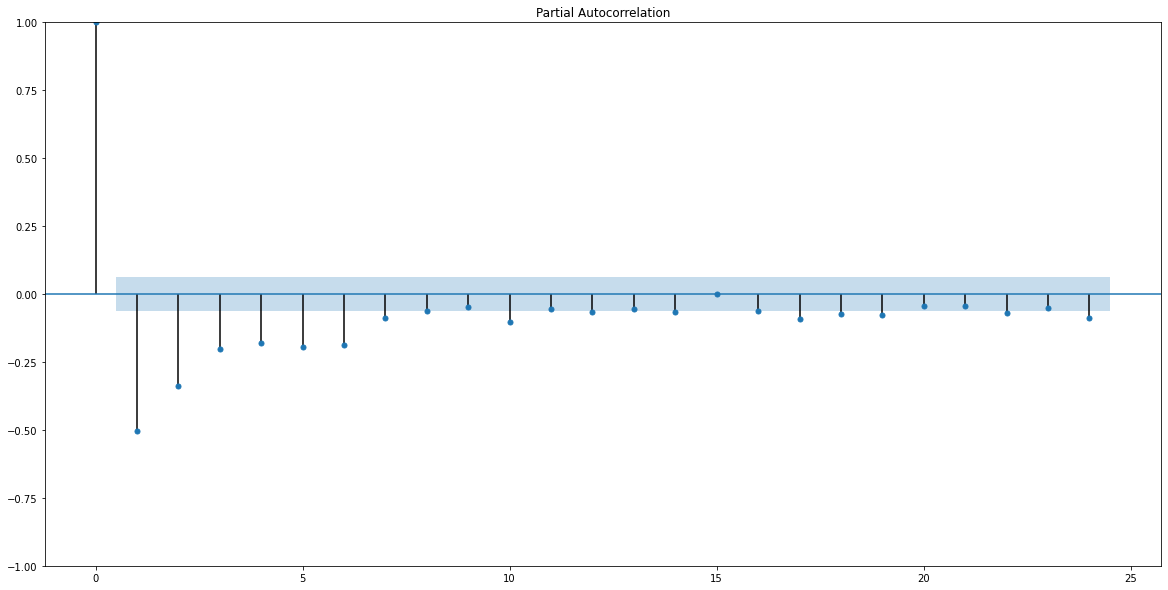

In [60]:
sm.graphics.tsa.plot_pacf(diff_semnome, lags=24)
plt.show()

##Análise ARIMA e ARIMA Sazonal##

In [61]:
white_noise = np.random.normal(size=1000)

In [62]:
c  = 10
ar1 = [1]
peso = 0.5

for i in range(0, len(white_noise)):
  ar1.append(c  + (peso*ar1[i]) + white_noise[i])


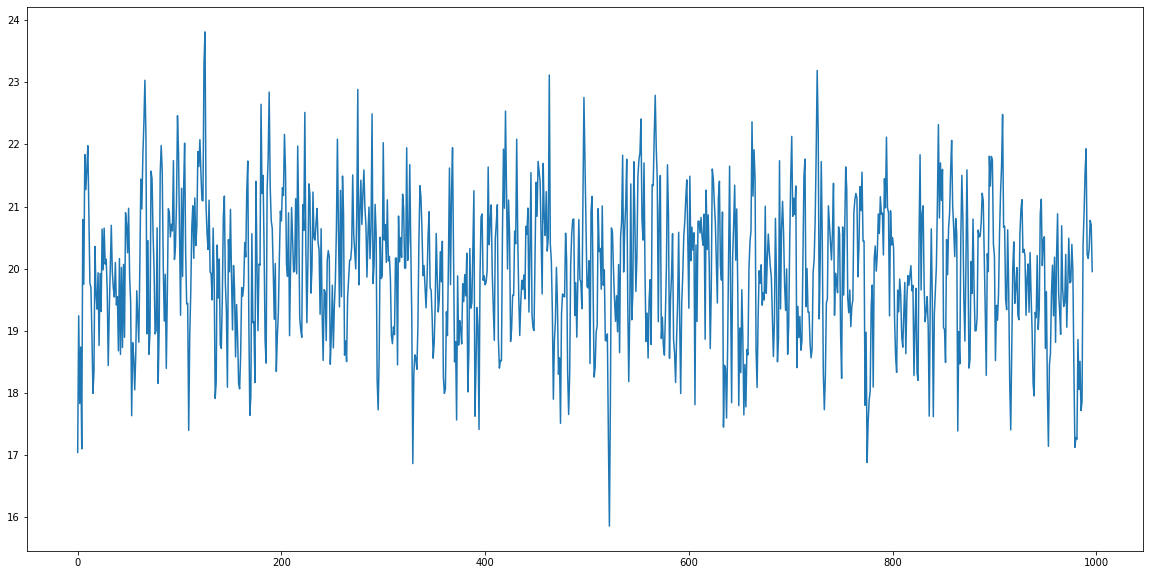

In [65]:
pd.Series(ar1[4:]).plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


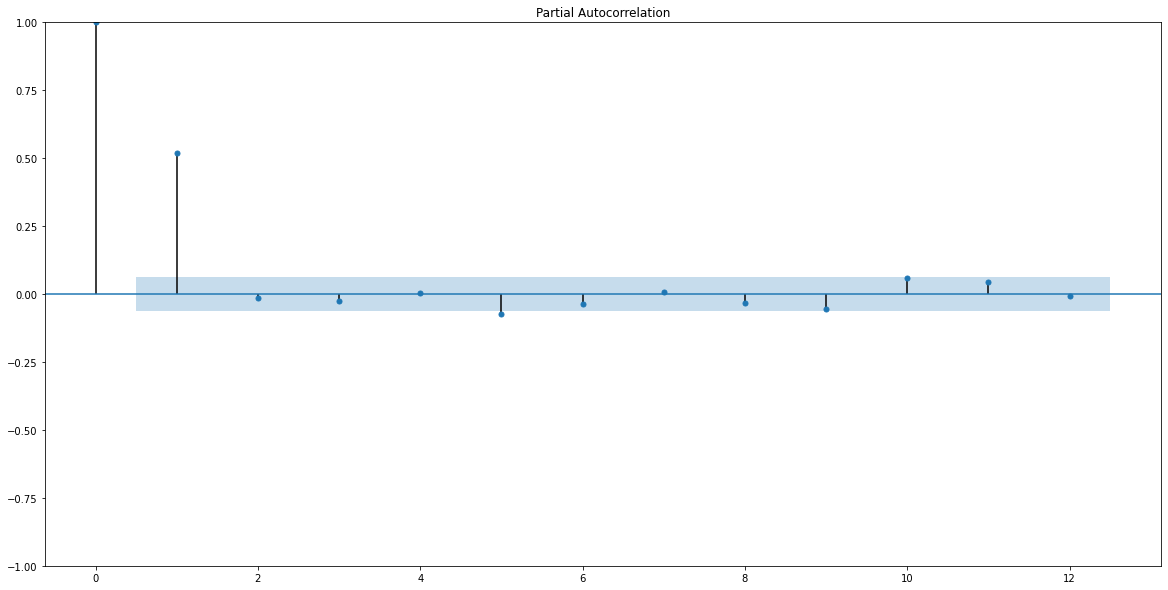

In [66]:
sm.graphics.tsa.plot_pacf(ar1[4:], lags=12)
plt.show()

In [63]:
c  = 10
ar2 = [1, 3]
peso1 = 0.4
peso2 = - 0.5 

for i in range(0, len(white_noise)):
  ar2.append(c  + (peso2*ar2[i]) + (peso1*ar2[i+1]) + white_noise[i])


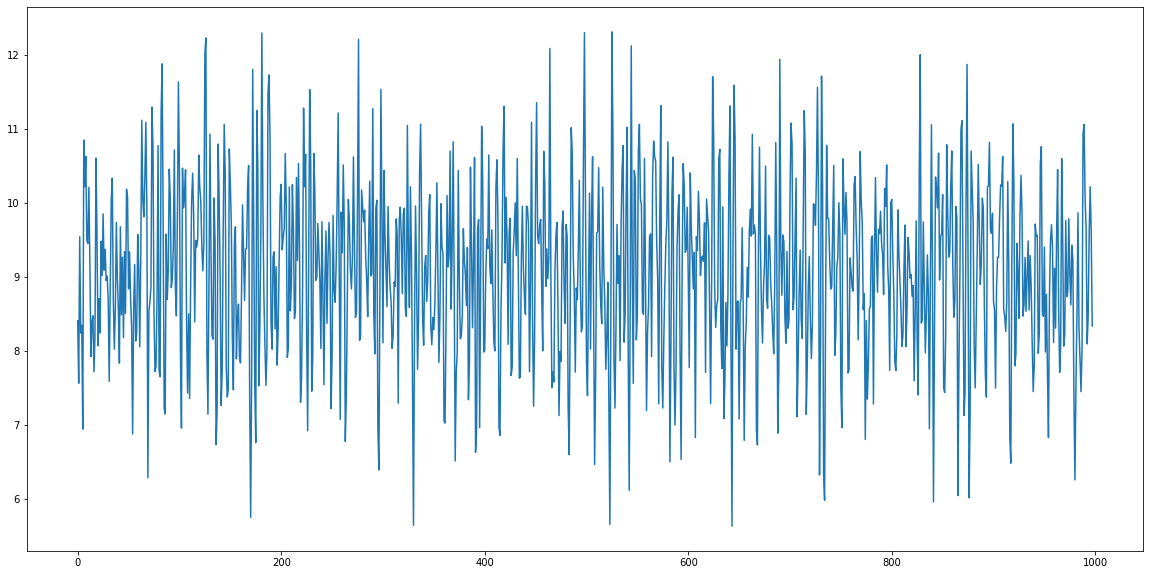

In [67]:
pd.Series(ar2[4:]).plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


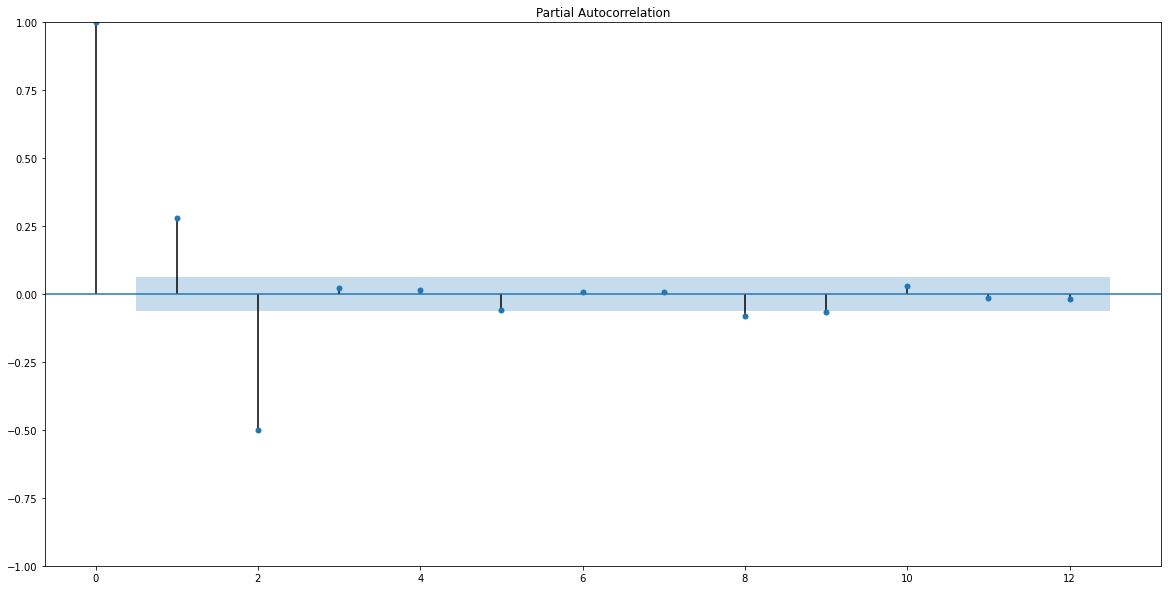

In [68]:
sm.graphics.tsa.plot_pacf(ar2[4:], lags=12)
plt.show()